# 3D Fast Accurate Fourier Transform
## Complex to Complex

In [1]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

import time

In [2]:
%matplotlib inline    

## Loading FFT routines

In [3]:
gridDIM = 64

size = gridDIM*gridDIM*gridDIM

axes0 = 0
axes1 = 1
axes2 = 2

segment_axes0 = 0
segment_axes1 = 0
segment_axes2 = 0

normFactor = 0.0

DIR_BASE = "/home/robert/Documents/new1/FFT/code/FAFT-7/FAFT/FAFT128_C2C-master/"

# FAFT
_faft128_3D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT128_3D_C2C.so' )
_faft128_3D.FAFT128_3D_C2C.restype = int
_faft128_3D.FAFT128_3D_C2C.argtypes = [ctypes.c_void_p, 
                                         ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                         ctypes.c_int, ctypes.c_float]

cuda_faft = _faft128_3D.FAFT128_3D_C2C


## Initializing Data

## Gaussian

In [6]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2. , dtype=np.float32 )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p , dtype=np.float32 )*np.exp( - p**2*sigma**2/2. , dtype=np.float32 )

 Amplitude x =  5.0
 Amplitude p =  6.0
        
mu_x =  1.5
mu_y =  1.5
mu_z =  1.5
sigma_x =  1.0
sigma_y =  1.0
sigma_z =  1.0
   
n     =  64
dx    =  0.15625
dp    =  0.1875
           standard fft dp =  0.628318530718      
    
delta =  0.0046627424734
    
The Gaussian extends to the numerical error in single precision:
    min =  (1.90247e-29+0j)


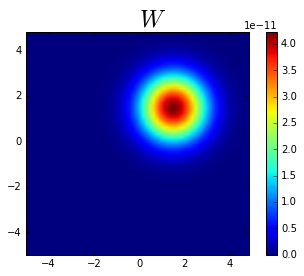

In [8]:
# Gaussian parameters
mu_x = 1.5
sigma_x = 1.

mu_y = 1.5
sigma_y = 1.

mu_z = 1.5
sigma_z = 1.

# Grid parameters
x_amplitude = 5.
p_amplitude = 6.                # With the traditional method p amplitude is fixed to: 2 * np.pi /( 2*x_amplitude ) 

dx = 2*x_amplitude/float(gridDIM)  # This is dx in Bailey's paper
dp = 2*p_amplitude/float(gridDIM)  # This is gamma in Bailey's paper

delta = dx*dp/(2*np.pi)

x_range = np.linspace( -x_amplitude, x_amplitude-dx, gridDIM)  
p = np.linspace( -p_amplitude, p_amplitude-dp, gridDIM) 

x = x_range[ np.newaxis, np.newaxis, : ] 
y = x_range[ np.newaxis, :, np.newaxis ] 
z = x_range[ :, np.newaxis, np.newaxis ] 

f =  Gaussian(x,mu_x,sigma_x)*Gaussian(y,mu_y,sigma_y)*Gaussian(z,mu_z,sigma_z)
f = f + 1j*np.zeros_like(f)

plt.imshow( f[:, :, 32].real, extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] , origin='lower' )

axis_font = {'size':'24'}
plt.text( 0., 5.1, '$W$' , **axis_font)
plt.colorbar()

print ' Amplitude x = ',x_amplitude
print ' Amplitude p = ',p_amplitude
print '        '

print 'mu_x = ', mu_x
print 'mu_y = ', mu_y
print 'mu_z = ', mu_z
print 'sigma_x = ', sigma_x
print 'sigma_y = ', sigma_y
print 'sigma_z = ', sigma_z
print '   '

print 'n     = ', x.size
print 'dx    = ', dx
print 'dp    = ', dp
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta = ', delta

print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '    min = ', np.min(f)

## $W$ TRANSFORM

In [9]:
F_gpu = gpuarray.zeros( ( gridDIM, gridDIM, gridDIM ), dtype=np.complex64 )

F_gpu[:,:,:] = f[:,:,:]

### Forward Transform

In [10]:
# Executing FFT

t_init = time.time() 

cuda_faft( int(F_gpu.gpudata), dx, delta, segment_axes0, axes0, normFactor )
cuda_faft( int(F_gpu.gpudata), dx, delta, segment_axes1, axes1, normFactor )
cuda_faft( int(F_gpu.gpudata), dx, delta, segment_axes2, axes2, normFactor )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  0.344394922256


(-6.0, 5.8125)

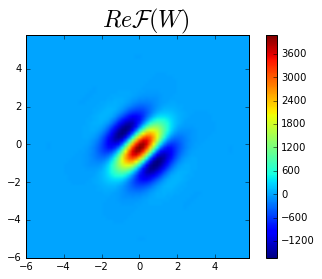

In [13]:
plt.imshow( F_gpu.get().real[:, 32, :]/float(np.sqrt(size)), 
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude, p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -2.0, 6.2, '$Re \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude-dp)
plt.ylim(-p_amplitude , p_amplitude-dp)

(-6.0, 5.8125)

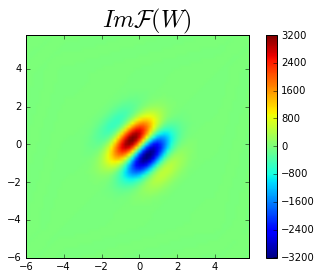

In [14]:
plt.imshow( F_gpu.get().imag[:, 32, :]/float(np.sqrt(size)), 
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude, p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -2.0, 6.2, '$Im \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude-dp)
plt.ylim(-p_amplitude , p_amplitude-dp)

### Inverse Transform

In [15]:
# Executing iFFT

cuda_faft( int(F_gpu.gpudata), dx, -delta, segment_axes0, axes0, normFactor )
cuda_faft( int(F_gpu.gpudata), dx, -delta, segment_axes1, axes1, normFactor )
cuda_faft( int(F_gpu.gpudata), dx, -delta, segment_axes2, axes2, normFactor )

1

(-5.0, 4.84375)

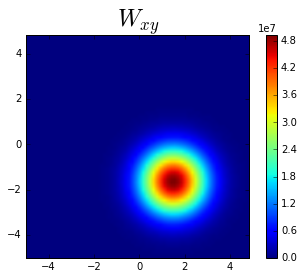

In [16]:
plt.imshow( F_gpu.get().real[32,:,:]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{xy}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

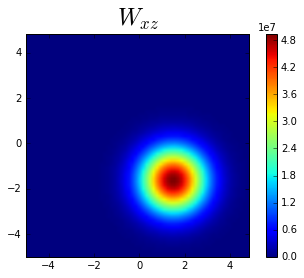

In [17]:
plt.imshow( F_gpu.get().real[:,32,:]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{xz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

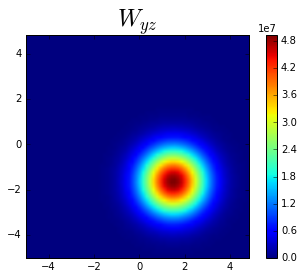

In [18]:
plt.imshow( F_gpu.get().real[:,:,32]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{yz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)